In [146]:
#libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [147]:
df = pd.read_csv("B.HEALTH_classification.csv")
base_df = df.drop(columns=["subject","day", "label"])

In [148]:
def cluster_ac(x, n_clusters):
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ac.fit(x)
    return ac.labels_

In [149]:
def cluster_DBSCAN(x):
    db = DBSCAN(metric='euclidean', eps=1.8)
    db.fit(x)
    return db.labels_

In [150]:
def cluster_kmeans(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(x)
    return kmeans.labels_

In [151]:
def normalize_data(x, how='minmax'):
    match how:
        case 'minmax':
            scaler = MinMaxScaler()
            return scaler.fit_transform(x)
        case 'standard':
            scaler = StandardScaler()
            return scaler.fit_transform(x)
        case 'none':
            return x

In [152]:
def reduce_df(X, n_components=2, how='pca'):
    match how:
        case 'pca':
            redux = PCA(n_components)
            return redux.fit_transform(X)
        case 'tsne':
            redux = TSNE(n_components)
            return redux.fit_transform(X)
        case 'none':
            return X

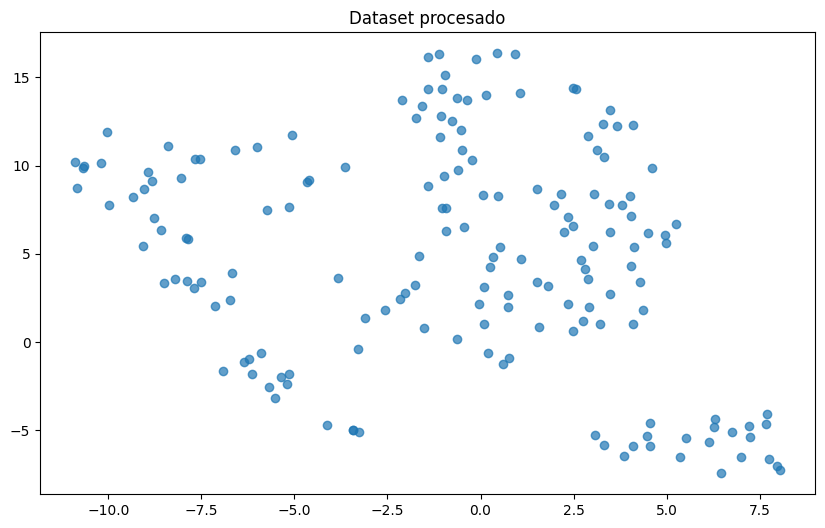

In [153]:
# Normalize the dataset
x_normalized = normalize_data(base_df, how='minmax')

# Reduce dimensions using TSNE
x_reduced = reduce_df(x_normalized, n_components=10, how='pca')

x_reduced_plot = reduce_df(x_normalized, n_components=2, how='tsne')

# Scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced_plot[:, 0], x_reduced_plot[:, 1], alpha=0.7)
plt.title('Dataset procesado')
plt.show()

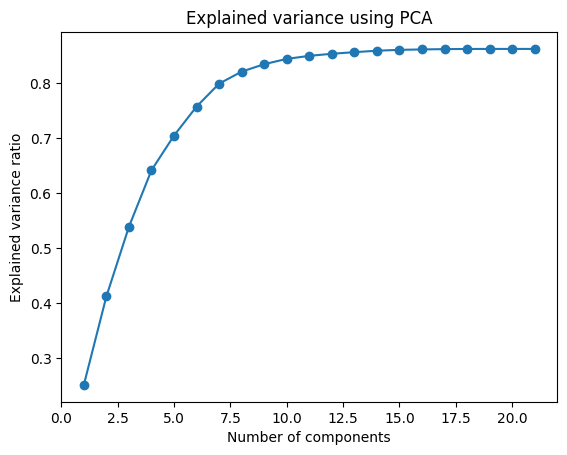

In [154]:
# Plot explained variance using PCA
pca = PCA(n_components=21)
pca_reduced = pca.fit_transform(x_normalized)
plt.plot(range(1, 22), np.cumsum(pca.explained_variance_), marker='o')
plt.title('Explained variance using PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

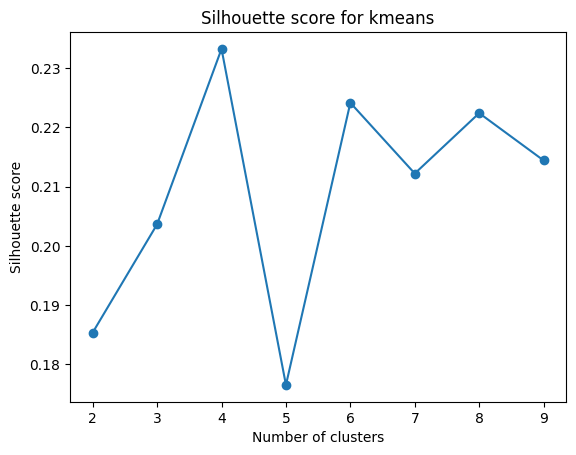

In [155]:
# Plot silhouette score for kmeans
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans_labels = cluster_kmeans(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, kmeans_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for kmeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

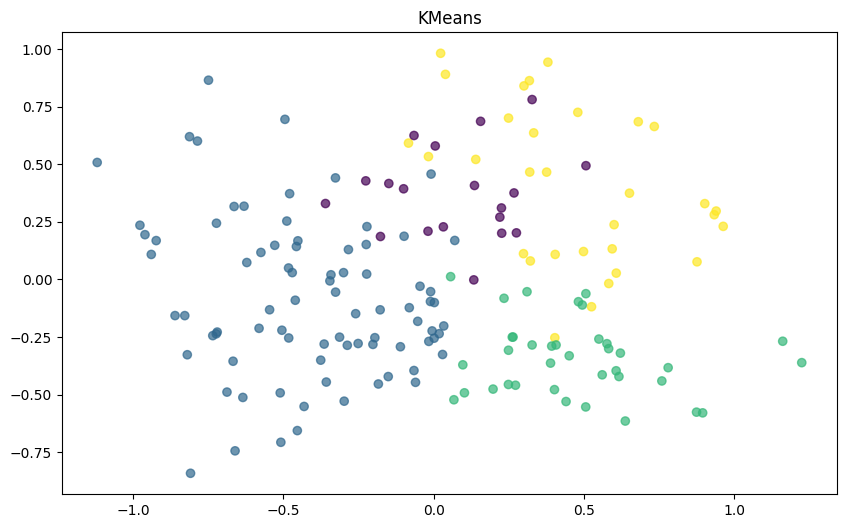

In [163]:
# Clusterize using KMeans
kmeans_labels = cluster_kmeans(x_reduced, n_clusters=4)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=kmeans_labels, alpha=0.7)
plt.title('KMeans')
plt.show()

In [157]:
# Print the data of the instances of each cluster from Kmeans
for cluster_num in np.unique(kmeans_labels):
    print(f"Cluster {cluster_num}:")
    cluster_data = base_df[kmeans_labels == cluster_num]
    print(cluster_data)
    print("\n")


Cluster 0:
     step count  distance travelled (km)  calories burnt (kcal)  \
26         9210                     5.01                    209   
28         7290                     5.30                    201   
29         7512                     6.25                    239   
30         7474                     5.75                    194   
31         7107                     5.31                    175   
32         8290                     6.30                    211   
33         6225                     5.12                    162   
34         7244                     5.69                    195   
35         5840                     4.59                    159   
36         3392                     2.48                     77   
52         1163                     0.84                     25   
54         1277                     0.91                     27   
57         4082                     2.78                    134   
60         3882                     2.71           

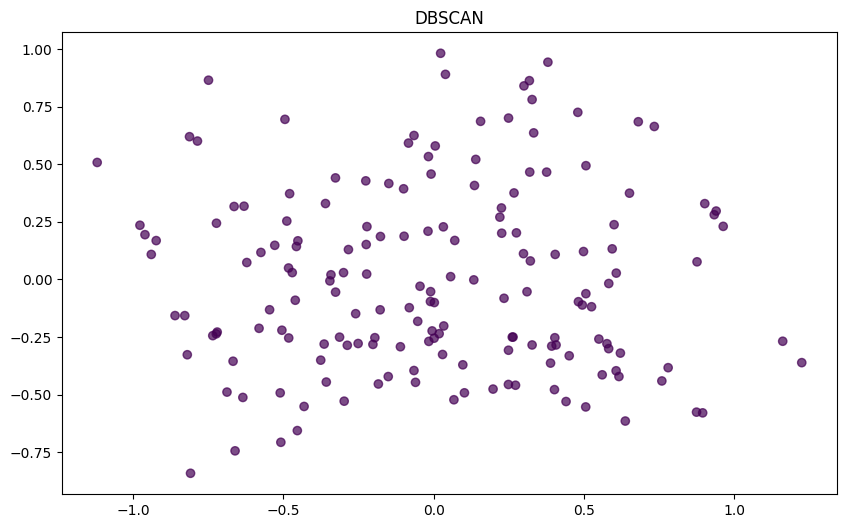

In [158]:
# Clusterize using DBSCAN
dbscan_labels = cluster_DBSCAN(x_reduced)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=dbscan_labels, alpha=0.7)
plt.title('DBSCAN')
plt.show()

In [159]:
# Print the data of the instances of each cluster from DBSCAN
for cluster_num in np.unique(dbscan_labels):
    if cluster_num == -1:
        continue
    print(f"Cluster {cluster_num}:")
    cluster_data = base_df[dbscan_labels == cluster_num]
    print(cluster_data)
    print("\n")


Cluster 0:
     step count  distance travelled (km)  calories burnt (kcal)  \
0          3016                     2.28                   2151   
1          1790                     1.39                   2129   
2          2864                     2.07                   2032   
3          1419                     1.80                   1713   
4          1698                     1.30                   1725   
..          ...                      ...                    ...   
163        6752                     4.59                    222   
164        6207                     3.89                    201   
165        6202                     4.21                    204   
166        1011                     0.23                     19   
167         947                     0.12                     20   

     acive time (minutes)  actual sleep duration (minutes)  \
0                      32                              455   
1                      19                              320  

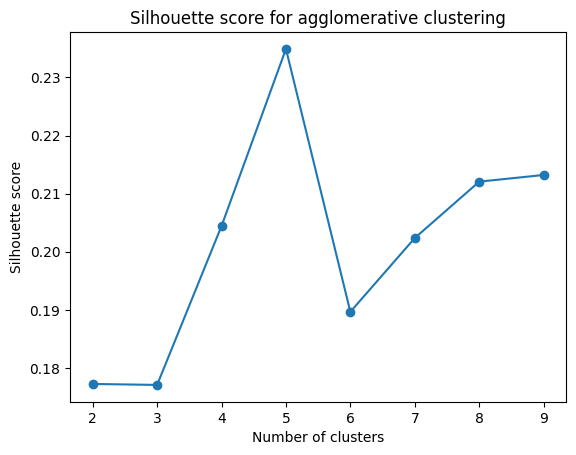

In [160]:
# Plot silhouette score for agglomerative clustering
silhouette_scores = []
for n_clusters in range(2, 10):
    agglomerative_labels = cluster_ac(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, agglomerative_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for agglomerative clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

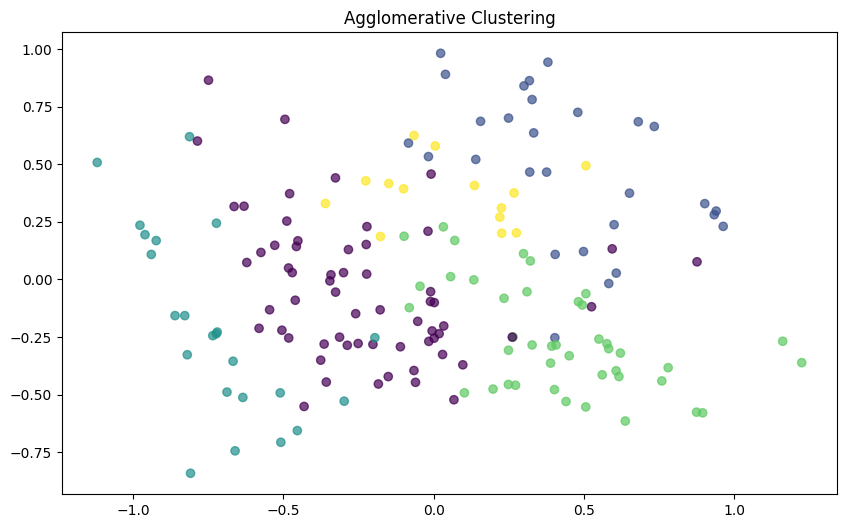

In [164]:
# Clusterize using agglomerative clustering
agglomerative_labels = cluster_ac(x_reduced, n_clusters=5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=agglomerative_labels, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.show()

In [162]:
# Print the data of the instances of each cluster from agglomerative clustering
for cluster_num in np.unique(agglomerative_labels):
    print(f"Cluster {cluster_num}:")
    cluster_data = base_df[agglomerative_labels == cluster_num]
    print(cluster_data)
    print("\n")

Cluster 0:
     step count  distance travelled (km)  calories burnt (kcal)  \
5          1722                     1.32                   1198   
7          2214                     1.71                    703   
10         2515                     1.95                    890   
31         7107                     5.31                    175   
33         6225                     5.12                    162   
35         5840                     4.59                    159   
36         3392                     2.48                     77   
52         1163                     0.84                     25   
57         4082                     2.78                    134   
60         3882                     2.71                    184   
61         3174                     2.22                    150   
62         1746                     1.21                     82   
64         2566                     1.79                    121   
66         3342                     2.33           